In [1]:
%%bash
DATA_DIR=/tmp/asd-diagnosis

if [ ! -d $DATA_DIR ]; then
  mkdir -p $DATA_DIR
fi

wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/functional_features.csv -O $DATA_DIR/functional_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_structural_features.csv -O $DATA_DIR/Harmonized_structural_features.csv &> .log
wget https://minio.131.154.99.37.myip.cloud.infn.it/hackathon-data/asd-diagnosis/Harmonized_functional_features.csv -O $DATA_DIR/Harmonized_functional_features.csv &> .log

ls -lrth $DATA_DIR/*

-rw-r--r-- 1 root root 417K Nov 14 10:10 /tmp/asd-diagnosis/functional_features.csv
-rw-r--r-- 1 root root 5.5M Nov 14 10:10 /tmp/asd-diagnosis/Harmonized_structural_features.csv
-rw-r--r-- 1 root root 133M Nov 14 10:12 /tmp/asd-diagnosis/Harmonized_functional_features.csv


In [2]:
import logging, os
logging.disable(logging.WARNING)
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Autism Spectrum Disorders (ASD) diagnosis using structural and functional Magnetic Resonance Imaging and Radiomics

Autism spectrum disorders (**ASD**) are a heterogeneous group of neurodevelopmental disorders characterized by persistent deficits in reciprocal social interaction, communication, and the presence of restricted, repetitive behaviors and interests, which can include sensory processing difficulties.
Despite ASD being currently diagnosed through a multidisciplinary and comprehensive direct evaluation of the individual with suspected ASD, associated with gold-standard behavioral observation and interview performed by clinicians expert in neurodevelopmental disorders, neuroimaging is playing a key role in identifying the neural correlates of this condition. In particular, machine learning (ML) and deep learning (DL) techniques are gaining considerable importance in supporting the diagnosis of ASD on the basis of magnetic resonance imaging (MRI) though these modalities do not have yet a clinical application. Early identification of the ASD can really help patients to manage the possible issues they may encounter given their condition.


## Dataset and features extraction
Since we want you to learn and understand deep learning based models, the data we give to you are directly harmonized features. However, it is interesting to show you at least an idea on how we extracted them. The datasets we are going to use are the Autism Brain Imaging Data Exchange datasets [(ABIDE 1 and ABIDE 2)](http://fcon_1000.projects.nitrc.org/indi/abide/). Data you are analyzing are the T1-weighted structural MRI (sMRI) and resting-state functional MRI (rs-fMRI or fMRI) data of the ABIDE I and ABIDE II. These two datasets contain more than one thousand cases as well as controls. However, since there is an unbalancement as regard some patients characteristics we operated a patient selection as follows:

1. Since 97% of the subjects were under the age of 40 years, we limited to subjects aged 5 to 40 years only;
2. We restricted our analysis to male subjects, due to both the limited representation of female subjects in the ABIDE collection (less than 20% of subjects, spread over different sites and a wide age-range), and the sex differences in functional brain connectivity;
3. We excluded subjects with missing multimodal MRI data after using the preprocessing pipeline.

Once the patients have been selected, the feature extraction pipelines have been applied separately for sMRI and fMRI. This is necessary since the different nature of this kind of data.

### Structural MRI features extraction
The pipeline for the features extraction on structural MRI are the following:

1.  The sMRI scans have been processed with Freesurfer version 6.0 with the [recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all) pipeline. This procedure includes cortical surface modelling, spherical coordinate transformation, non-linear curvature registration, automated volumetric segmentation and cortical reconstruction.
2.  The following brain features have been selected: the global measures and the subcortical features available in the file aseg.stats and the cortical features available in the bilateral files aparc.stats.

In this way, a total number of 221 brain morphometric features have been obtained. These brain descriptive characteristics can be grouped into:

- **9 global quantities**: left (L) and right (R) mean thickness, L and R cortex volumes, L and R cerebral white matter
volume, cerebrospinal fluid volume, total gray volumes and the volume of segmented brain without ventricles;
- **26 volumes of sub-cortical** structures and corpus callosum;
- **186 measures**, including the volume, the mean and standard deviation of the thickness of 62 structures (31 per
hemisphere) from the **Desikan–Killiany–Tourville Atlas**: 14 in the temporal lobe, 20 in the frontal lobe, 10
in the parietal lobe, 8 in the occipital lobe and 10 in the cingulate cortex.

### Functional MRI features extraction

The rs-fMRI scans selected from ABIDE I and ABIDE II cohorts have been processed as follows:

1. The Configurable Pipeline for the Analysis of Connectomes (CPAC), that includes motion correction, slice timing correction, band-pass filtering, spatial smoothing and registration has been applied;
2. The Harvard-Oxford (HO) atlas was used to extract time series from brain regions, obtaining 103 timeseries for each subject.
3. The Pearson correlation was calculated between the timeseries of pairs of regions to derive a functional connectivity (FC) matrix.
4. The correlation values were normalized according to Fisher transformation in order to make them approximately normally-distributed.

This way, we obtain 5253 connectivity features for each subject. In the following, you can have an idea of what functional MRI features are.

In [3]:
import pandas as pd

path_to_data = '/tmp/asd-diagnosis/'

functional_names = pd.read_csv(path_to_data + 'functional_features.csv')
functional_names = functional_names.set_index('F')

functional_names

,ROI 1,ROI 2,r1,r2
F,,,,
0,101,102,Right Frontal Pole,Left Frontal Pole
1,101,2202,Right Frontal Pole,"Left Lateral Occipital Cortex, superior division"
2,102,2202,Left Frontal Pole,"Left Lateral Occipital Cortex, superior division"
3,101,2201,Right Frontal Pole,"Right Lateral Occipital Cortex, superior division"
4,102,2201,Left Frontal Pole,"Right Lateral Occipital Cortex, superior division"
...,...,...,...,...
5248,901,4702,"Right Superior Temporal Gyrus, anterior division",Left Supracalcarine Cortex
5249,4501,4702,Right Heschl's Gyrus (includes H1 and H2),Left Supracalcarine Cortex
5250,902,4702,"Left Superior Temporal Gyrus, anterior division",Left Supracalcarine Cortex


## Feature Harmonization
Due to the multisite nature of the dataset, we separately harmonized the Freesurfer structural features and the
functional connectivity measures using the publicly available Python package NeuroHarmonize, which is the state-of-
the-art tool for multi-site neuroimaging analysis developed by Pomponio et al. 
We estimated the NeuroHarmonize model parameters on the entire cohort of **control** subjects, by specifying the age as a covariate, whose effect is to be preserved during the harmonization process. Finally, we applied the estimated model on the entire sample of subjects with ASD and TD controls.

# Exercise: first part

Here, you will have to read the data and pre-process them. First you need to import the necessary libraries and the apply a scaler to the data.


In [4]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Data pre-processing

As discussed this morning, the available data has already been pre-processed using Neuroharmonize package. This was needed to delete the site bias.

MRI images are prone to acquisition site bias. So anytime you want to perform an analysis on MRI and you have the acquisition site information, the harmonization is mandatory.

Usually harmonizing data leads to a performance decrease. Even if this could seem a nasty problem, it is more important to perform unbiased analysis than having a high but fake accuracy :)

We decided to avoid the harmonization part because it may take long time and we prefer to focus on models. 
Even if a first pre-processing has been already done, there are still some missing procedures you have to do.

1) Load data from both structural and functional MRI

In [5]:
path_to_data = '/tmp/asd-diagnosis/'

DF_struct = pd.read_csv(path_to_data + 'Harmonized_structural_features.csv')
DF_funct = pd.read_csv(path_to_data + 'Harmonized_functional_features.csv')

> - Set the DataFrame index using 'FILE_ID'
> - Drop the variable that are redundant
> - Merge the two DataFrame

DX_GROUP is the target variable, i.e. Autism Spectrum Disorder or Typical Development.

In [6]:
DF_struct = DF_struct.set_index('FILE_ID')
DF_funct = DF_funct.set_index('FILE_ID')
DF_funct= DF_funct.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'DX_GROUP'], axis =1)
DF_merge = DF_struct.join(DF_funct,how='inner')
DF_merge = DF_merge.reset_index()
DF_merge.loc[DF_merge.DX_GROUP == -1, 'DX_GROUP'] = 0
DF_merge

,FILE_ID,Database_Abide,SITE,AGE_AT_SCAN,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,51457,1.0,CALTECH,22.9,1,4688.148643,2.930110,0.587509,8800.363280,2.325779,...,-2.705760,-4.941687,-0.313784,-1.580897,-0.578138,0.800900,1.147299,-0.890745,4.318482,1.020236
1,51458,1.0,CALTECH,39.2,1,3984.677523,2.882359,0.460643,6547.377947,2.435749,...,-1.542383,-2.030129,0.686534,-3.049052,1.500650,-0.057321,-0.400296,0.395253,3.167437,-0.097813
2,51459,1.0,CALTECH,22.8,1,4784.864858,2.737028,0.637104,9181.350601,2.683773,...,3.010815,1.032087,-0.068159,-3.309840,-0.691436,-0.463286,-1.549897,0.358268,1.696029,-1.191784
3,51461,1.0,CALTECH,37.7,1,2139.453979,2.286036,0.518532,6268.548302,2.528375,...,2.469967,2.228592,-1.300355,1.016235,0.685534,-1.513635,0.778284,1.085581,-2.308573,-2.923374
4,51464,1.0,CALTECH,20.9,1,6194.078262,2.955411,0.831313,11308.319412,2.380809,...,1.399667,-1.951666,-1.588347,-0.684389,-1.423833,0.770992,-2.364999,3.107560,1.168626,-0.658174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,30244,2.0,U_MIA_A,9.5,0,2760.894710,2.719528,0.645727,8044.910494,2.797142,...,-2.494394,-2.287528,-2.692700,0.572010,-2.051990,-2.813308,-2.631377,-0.497931,5.814645,-1.464597
1379,30249,2.0,U_MIA_A,12.4,0,3978.719928,2.766787,0.606700,7192.725506,2.764371,...,-1.049086,-0.655575,2.143340,-4.697099,-0.670624,0.330856,-0.364826,2.593785,3.250819,1.271162
1380,30250,2.0,U_MIA_A,10.1,0,2954.162825,2.897091,0.770469,8104.601082,2.905285,...,0.638060,3.033216,-0.703276,0.765123,-0.741325,-0.049255,1.498713,-0.294101,9.475724,-0.006066
1381,30252,2.0,U_MIA_A,11.3,0,3276.342103,2.925723,0.678409,7901.169064,2.882859,...,-2.245569,1.083005,-0.479682,-0.084593,2.388419,-1.887193,2.116627,-2.294673,5.933953,0.806741


> Before going through the exercise, let's plot the histogram of the patients versus the acquisition site.

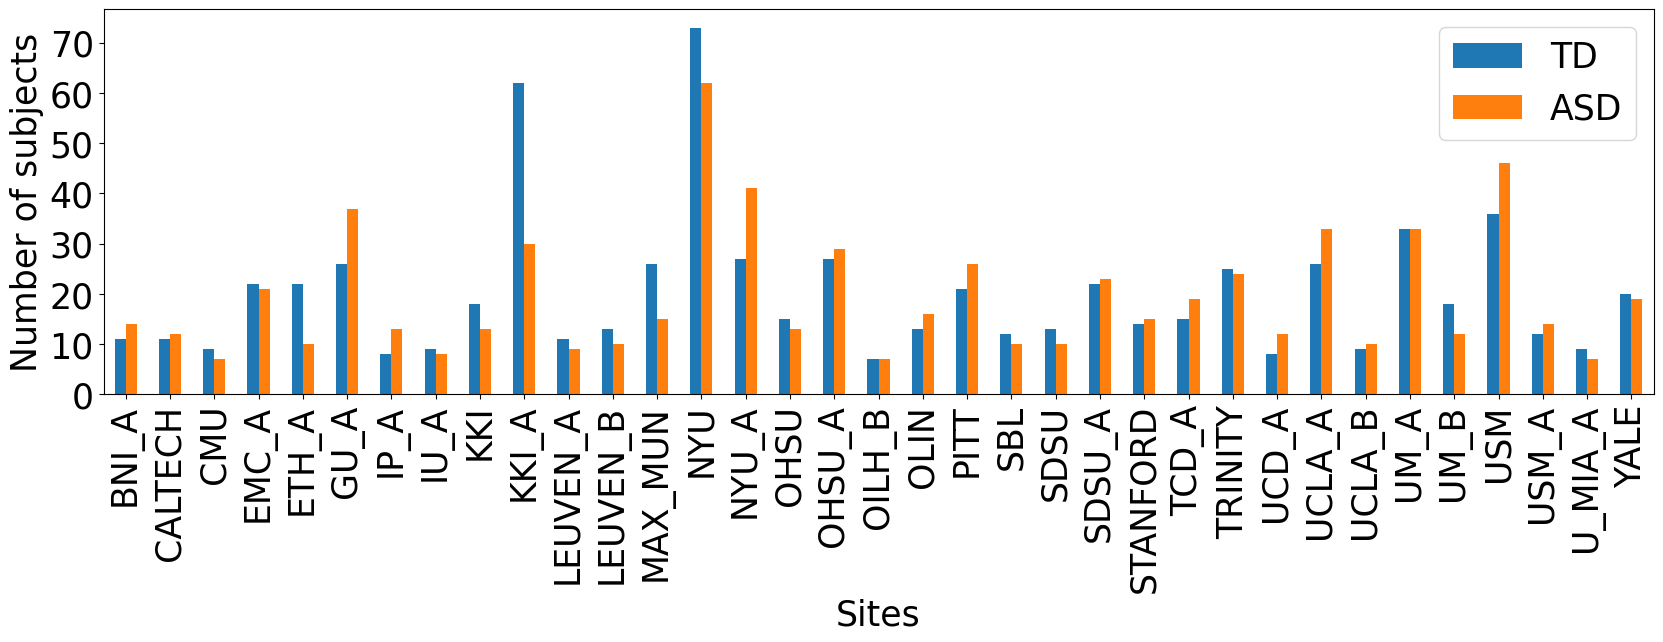

In [7]:
stack = DF_merge.groupby(['SITE', 'DX_GROUP'])['SITE'].count()
unstacked = stack.unstack('DX_GROUP')
ax = unstacked.plot(kind='bar', stacked=False, fontsize = 25, figsize=(20,5))
ax.legend(["TD", "ASD"], fontsize=25);
plt.ylabel('Number of subjects', fontsize = 25)
plt.xlabel('Sites', fontsize = 25)
plt.show()

> - Normalize the data using [RobustScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html) of scikit learn.

In [8]:
DF_normalized = DF_merge.drop(['SITE', 'Database_Abide', 'AGE_AT_SCAN', 'FILE_ID'], axis =1)

In [9]:
#normalize data
RS_instance = RobustScaler()
DF_normalized.iloc[:,1:] = RS_instance.fit_transform(DF_normalized.iloc[:,1:].to_numpy())
DF_normalized

,DX_GROUP,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalmiddlefrontal_GrayVol,lh_caudalmiddlefrontal_ThickAvg,lh_caudalmiddlefrontal_ThickStd,lh_cuneus_GrayVol,lh_cuneus_ThickAvg,lh_cuneus_ThickStd,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,1.268638,0.377530,-0.589783,0.326769,-1.746200,0.977805,-0.930078,-0.735032,0.054484,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.435023,0.195201,-1.497886,-0.869530,-1.260341,0.149260,-1.395270,-0.014497,-0.708084,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,1.383247,-0.359718,-0.234784,0.529067,-0.164543,1.139456,-0.313275,-0.094698,0.732500,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,-1.751570,-2.081748,-1.083519,-1.017585,-0.851110,0.637108,-1.274742,-0.708439,-0.928185,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,3.053168,0.474139,1.155356,1.658454,-1.503074,0.539329,-0.320901,-0.005986,0.303621,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,-1.015162,-0.426538,-0.173057,-0.074364,0.336335,0.698862,-0.313788,-0.039112,0.038536,...,-0.483189,-0.679837,-0.878889,0.287663,-0.708784,-0.819811,-0.903062,-0.024219,0.139968,-0.455778
1379,0,0.427964,-0.246087,-0.452409,-0.526861,0.191545,-0.374590,0.293213,-0.100998,0.172274,...,0.027758,-0.072346,1.003167,-1.517439,-0.235011,0.312947,-0.086953,1.080796,-0.500728,0.568892
1380,0,-0.786139,0.251453,0.719843,-0.042670,0.814119,0.230835,0.368386,0.695370,0.510382,...,0.624201,1.300800,-0.104659,0.353820,-0.259260,0.176004,0.584045,0.048632,1.054866,0.090510
1381,0,-0.404356,0.360779,0.060875,-0.150689,0.715041,0.046943,0.291748,0.349174,-0.664107,...,-0.395224,0.574837,-0.017642,0.062723,0.814161,-0.486156,0.806535,-0.666395,0.169783,0.394945


# Classification ASD/TD using only structural features

- Now you have to develop the model using the structural features.

In [10]:
import shap

import numpy as np
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import SGD #stochastic gradient descent

In [11]:
def structural_model():
  input_data= Input(221,)
  x = Dense(32,  'relu', kernel_initializer='normal', kernel_regularizer=l1(0.01))(input_data)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x) #glorot_normal
  x = BatchNormalization()(x)
  #x = Dropout(0.1)(x)
  x = Dense(1, 'sigmoid', kernel_regularizer=l1(0.01))(x)
  struct_model = tf.keras.Model(inputs=input_data, outputs=x)
  return struct_model

### Callback

A callback is an action passed to the model fit function which is performend while training the neural network. These actions allow you to modify certain parameters when a specific condition is met while training. These actions may be implemented before or after an epoch or batch is processed, when training begins or ends and when a specific condition is met. Callbacks can help with tasks like saving the model, reducing learning rates, stopping training early, or logging performance metrics. Here we implement two actions:

* EarlyStopping
* ReduceLROnPlateau

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

## Cross-validation setting
Usually, when we train a deep learning algorithm, we divide the data set into three sets:
1. Training set;
2. Validation set;
3. Test set.

The algorithm is trained on the training set and evaluated on the validation set during the training phase. The test set is used once the algorithm performs well on the validation set.

In this case, since the number of patient is low with respect to the number of features and the computing burden allows it, we will train the algorithm in a cross validation fashion.

The entire data set will be divided into 10 folds and 1 is used as validation and the remaining will be used as training set. This way, we can consider the algorithm performance more stable. In fact, the main drawback of using train, validation and test is the possibility that the samples in the test set do not reflect the entire variability of the data. Using cross-validation, we are cyclically validate the algorithm on the entire data set.

In [13]:
n_cv = 10 #number of folds
AUC = []
acc = []
shap_values_per_cv = []
tprs = []
aucs = []
np.random.seed(1) # Reproducibility
rs_ = 13 # Reproducibility, random state for division in folds

interp_fpr = np.linspace(0, 1, 100)

Now, first we used the StratifiedKFold of scikit learn to divide and manage our sub sets of data.
Then, we train 10 models using the cross validation. 
So we use a for cycle to slide along the 10 subset and we will use one of them as test/validation and the remaining data as training set.

For each traning we will also register the shap values that will help to explain the behaviour of our algorithm. Once the values are collected for each fold, we will average them per features, obtaining the most important average features that contribute to the classification.

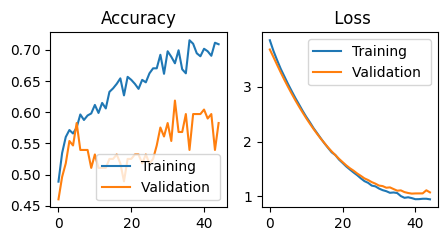

5/5 [==============================] - 0s 2ms/step


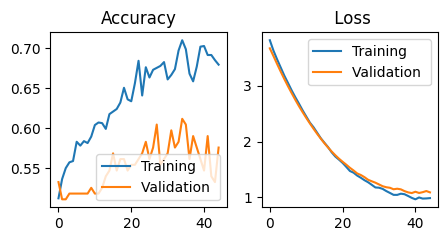

5/5 [==============================] - 0s 2ms/step


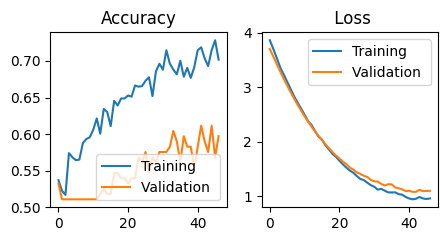

5/5 [==============================] - 0s 2ms/step


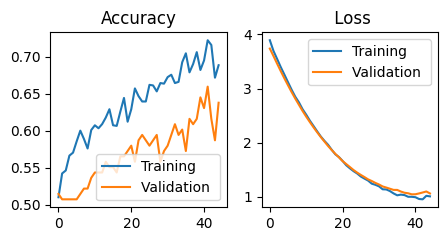

5/5 [==============================] - 0s 2ms/step


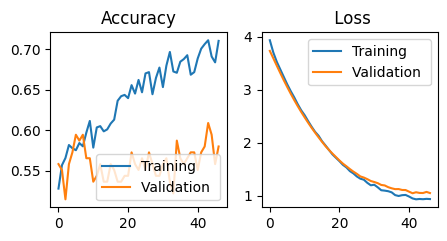

5/5 [==============================] - 0s 2ms/step


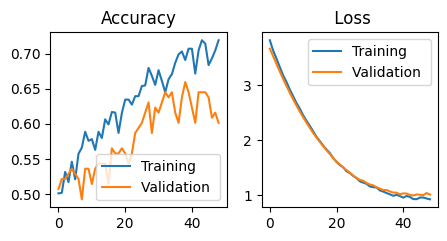

5/5 [==============================] - 0s 2ms/step


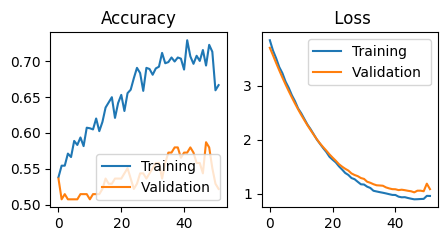

5/5 [==============================] - 0s 2ms/step


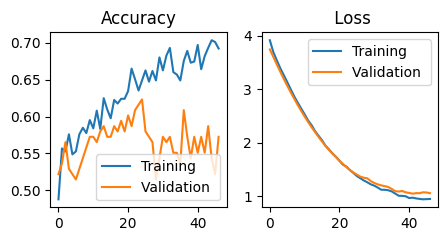

5/5 [==============================] - 0s 2ms/step


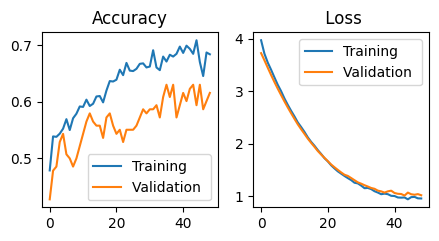

5/5 [==============================] - 0s 2ms/step


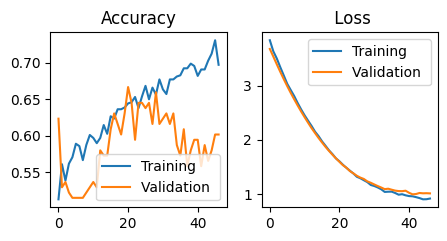

5/5 [==============================] - 0s 2ms/step


In [14]:
cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=rs_) 

for train_index, test_index in cv.split(DF_normalized.iloc[:, 1:], DF_normalized.iloc[:, 0]):
    clear_session() # to ensure that no weights of other folds remain in memory

    df_train, df_test = DF_normalized.iloc[train_index, :222], DF_normalized.iloc[test_index, :222]
        
    X_train, X_test = df_train.iloc[:, 1:], df_test.iloc[:, 1:]
    y_train, y_test = df_train.iloc[:, 0], df_test.iloc[:, 0]

    #load the model
    model_struct = structural_model()

    # Compile the model
    model_struct.compile(optimizer=SGD(learning_rate = 0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Fit data to model
    history = model_struct.fit(X_train, y_train,
          batch_size=64,
          epochs=150,
          validation_data = (X_test, y_test),
          verbose=0,
          callbacks=[reduce_on_plateau, early_stop]) 

        ###########################################################
    
    #Train and validation accuracy
    
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training ')
    plt.plot(history.history['val_accuracy'], label='Validation ')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    #Train and validation loss
    
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training ')
    plt.plot(history.history['val_loss'], label='Validation ')
    plt.legend(loc='upper right')
    plt.title(' Loss')
    plt.show()
    
    
    ###########################################################
    # prepare for SHAP
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # Use SHAP to explain predictions
    explainer = shap.GradientExplainer(model_struct, [X_train]) # the explainer is initialized on training set
    shap_values = explainer.shap_values(X_test) # the values are computed on the validation set

    #  SHAP information per fold per sample
    
    shap_values_per_cv.append(shap_values[:138])
    
        ###########################################################
    _, val_acc = model_struct.evaluate(df_test.iloc[:, 1:], df_test.iloc[:, 0], verbose=0)
    acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
    i=0
    preds = model_struct.predict(df_test.iloc[:, 1:], verbose=1)
    fpr, tpr, _ = roc_curve(df_test.iloc[:, 0], preds)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    AUC.append(roc_auc)
    i += 1

# ROC curve plot

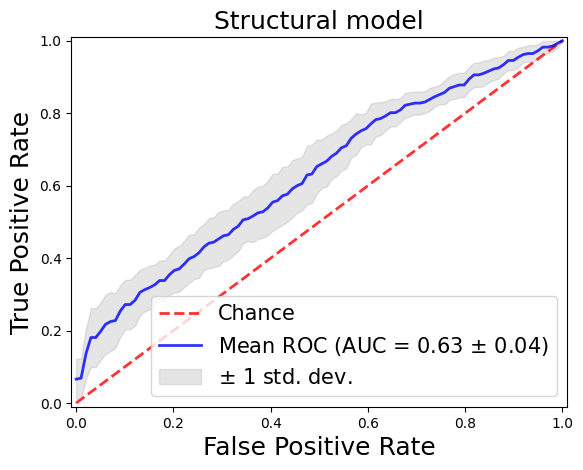

In [15]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Structural model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

## Results in terms of accuracy and AUC

In [16]:
print(f'AUC: {np.mean(AUC):.4f} (+- {np.std(AUC):.4f})')
print(f'accuracy: {np.mean(acc):.4f} (+- {np.std(acc):.4f})')

AUC: 0.6268 (+- 0.0414)
accuracy: 0.5886 (+- 0.0293)


# Explain the results

In [17]:
average_shap_values_s = []

for i in range(0, len(AUC)):
    df_per_obs = shap_values_per_cv[i].copy()
    df_per_obs = np.absolute(df_per_obs)
    average_shap_values_s.append(df_per_obs.mean(axis=0))

fold_s = np.array(average_shap_values_s)[...,0]

In [18]:
fold_s.shape

(10, 221)

In [19]:
mean_s = np.mean(fold_s, axis = 0)
std_s = np.std(fold_s, axis = 0)

In [20]:
shap_struct = pd.DataFrame({"SHAP_values": mean_s}, index = df_train.iloc[:, 1:].columns)
shap_struct['std']=std_s
shap_struct = shap_struct.sort_values(by='SHAP_values', ascending=False)
shap_struct

,SHAP_values,std
lh_superiortemporal_ThickAvg,0.022381,0.004091
Left-VentralDC_Volume_mm3,0.016124,0.005318
Right-Hippocampus_Volume_mm3,0.015334,0.006534
lh_entorhinal_GrayVol,0.014457,0.005886
rh_paracentral_ThickAvg,0.014271,0.004765
...,...,...
TotalGrayVol,0.001843,0.001308
rh_lateraloccipital_ThickAvg,0.001826,0.000695
rh_MeanThickness,0.001613,0.000905
lh_lateralorbitofrontal_ThickStd,0.001527,0.000283


## Visualize SHAP values and standard deviation

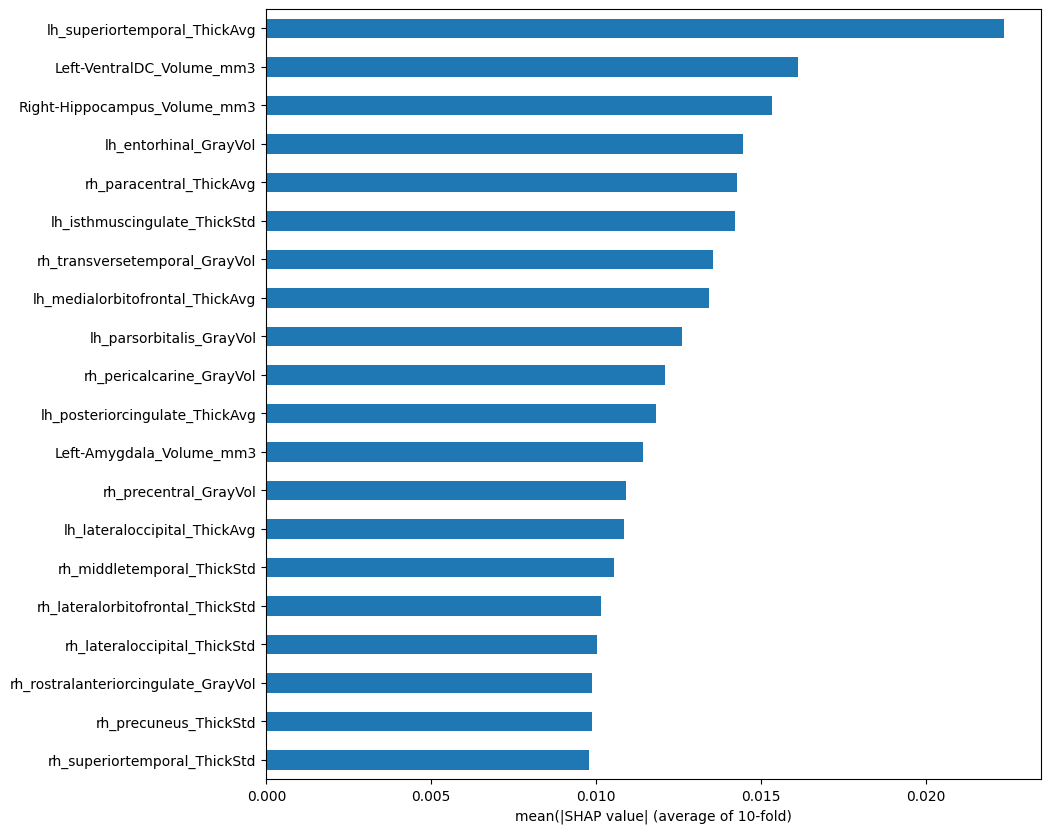

In [43]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = shap_struct.iloc[:20,0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value| (average of 10-fold)")
plt.show()

<Figure size 4000x5000 with 0 Axes>

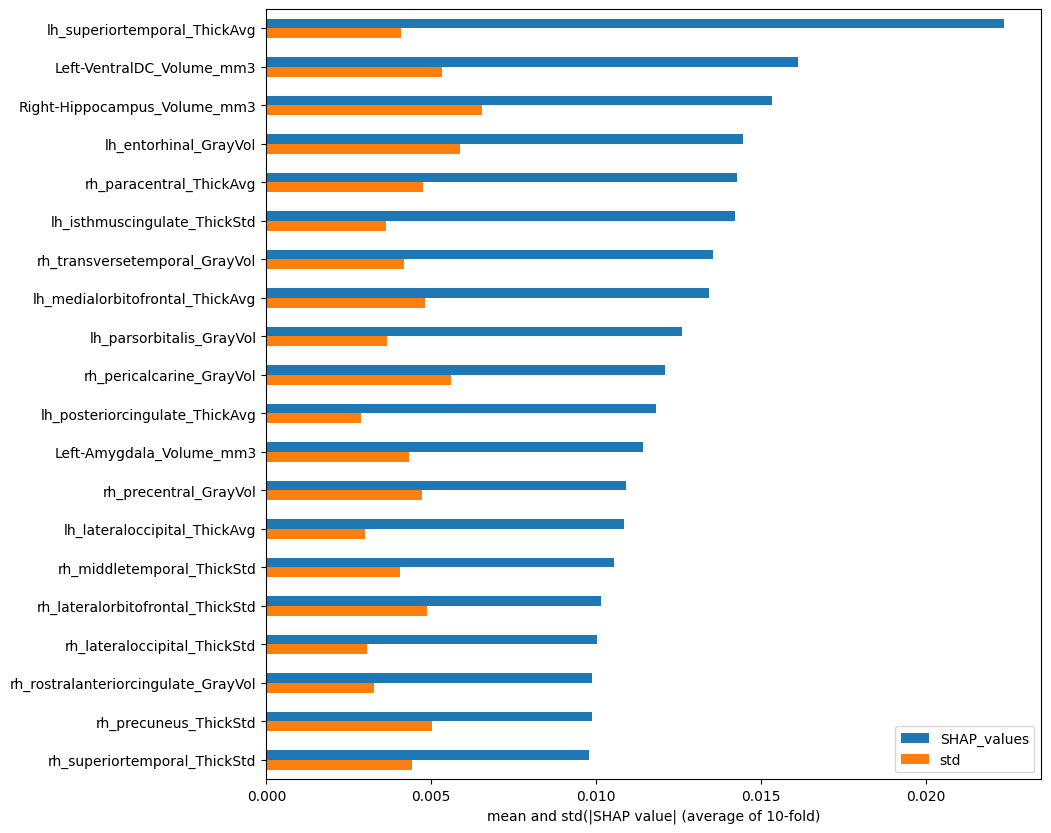

In [44]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = shap_struct.iloc[:20].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean and std(|SHAP value| (average of 10-fold)")
plt.show()

## Cohen d coeff

The Cohen's *d* coefficient is a statistical measure used to quantify the *effect size* between two groups, indicating the standardized difference between their means. It is commonly used in psychology, social sciences, and other fields to assess the difference between two sample groups.

### Formula

The formula for Cohen’s *d* is:
$$
d = \frac{\bar{X}_1 - \bar{X}_2}{s}
$$
where: $\bar{X}_1$ and $\bar{X}_2$ are the means of the two groups. $s$ is the pooled standard deviation of the two groups, calculated as:
$$
s = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}
$$
where: $n_1$ and $n_2$ are the sample sizes of the two groups. $s_1$ and $s_2$ are the standard deviations of the two groups.

### Interpretation
Cohen's *d* provides a way to interpret the magnitude of the difference, regardless of the scale of the data, making it easier to compare across studies. Common interpretations are:
- **0.2** - Small effect size
- **0.5** - Medium effect size
- **0.8** or higher - Large effect size

These are general guidelines, and the interpretation can vary by field. Cohen's *d* is particularly helpful because it puts the difference in a standardized context, allowing researchers to understand the size of an effect without being influenced by sample size alone.

In [23]:
def Cohen(g1, g2, f):
    n1 = len(g1)
    n2 = len(g2)
    N = n1 + n2
    Scores1 = g1[f].dropna()
    Scores2 = g2[f].dropna()
    var1 = Scores1.var()
    var2 = Scores2.var()
    mean1 = Scores1.mean()
    mean2 = Scores2.mean()
    sp = (((n1 - 1)*var1 + (n2 - 1)*var2) / (N - 2))**0.5
    d = (mean1 - mean2) / sp
    return d

In [24]:
controls = df_train[df_train.DX_GROUP==0]
ASD =  df_train[df_train.DX_GROUP==1]
list_f = shap_struct.index.tolist()
cohen_val = {'Feature Name': [], 'Cohen Value' : []}
for item in list_f:
    score =  Cohen(ASD, controls, item)
    cohen_val['Feature Name'].append(item)
    cohen_val['Cohen Value'].append(score)

cohen_struct = pd.DataFrame(cohen_val)
cohen_struct.set_index('Feature Name')
cohen_struct = cohen_struct.sort_values(by='Cohen Value', ascending=False)

In [25]:
cohen_struct

,Feature Name,Cohen Value
14,rh_middletemporal_ThickStd,0.292186
19,rh_superiortemporal_ThickStd,0.286062
26,lh_inferiortemporal_ThickStd,0.264280
18,rh_precuneus_ThickStd,0.263408
107,lh_fusiform_ThickStd,0.248764
...,...,...
4,rh_paracentral_ThickAvg,-0.103116
93,rh_precentral_ThickAvg,-0.106000
28,CC_Mid_Anterior_Volume_mm3,-0.127299
9,rh_pericalcarine_GrayVol,-0.134320


# Classification ASD/TD using only functional features

We repeat the same procedure we did for the structural feature.

In [26]:
def functional_model():
  input_data= Input(5253,)
  x = Dense(64, 'relu', kernel_initializer= 'normal', kernel_regularizer=l1(0.01))(input_data)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(32, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(16, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(8, 'relu',kernel_initializer='normal', kernel_regularizer=l1(0.01))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.1)(x)
  x = Dense(1, 'sigmoid', kernel_regularizer=l1(0.01))(x)
  func_model = tf.keras.Model(inputs=input_data, outputs=x)
  return func_model

In [27]:
DF_normalized.iloc[:,0] # Grabs all rows and first 2 columns
DF_normalized.iloc[:,222:] # Grabs all rows and last 2 columns

DF_normalized= pd.concat([DF_normalized.iloc[:,0],DF_normalized.iloc[:,222:]],axis=1) # Puts them together row wise
DF_normalized

,DX_GROUP,0,1,2,3,4,5,6,7,8,...,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252
0,1,0.583748,2.193025,0.673619,0.728404,0.544552,0.314620,1.486942,1.736285,0.951194,...,-0.557912,-1.667843,0.046921,-0.449884,-0.203291,0.482292,0.457513,-0.164615,-0.233920,0.474908
1,1,0.209670,0.954039,1.038003,1.169329,1.893902,0.835057,0.737108,1.166317,0.003677,...,-0.146633,-0.584021,0.436218,-0.952848,0.509680,0.173098,-0.099725,0.295015,-0.521565,0.056147
2,1,0.852755,-1.235192,-0.929105,-0.907786,-0.626890,0.915277,1.934611,2.182828,0.755814,...,1.463021,0.555883,0.142512,-1.042189,-0.242149,0.026839,-0.513657,0.281796,-0.889267,-0.353597
3,1,0.395910,0.379259,0.843448,0.087678,0.858482,0.783376,-0.911812,0.013849,0.126862,...,1.271820,1.001280,-0.337026,0.439847,0.230116,-0.351573,0.324643,0.541746,-1.890011,-1.002159
4,1,-0.398496,-0.104224,0.224026,0.319259,-0.122613,-1.579841,0.498455,0.969507,-1.619587,...,0.893446,-0.554813,-0.449105,-0.142757,-0.493343,0.471517,-0.807148,1.264425,-1.021064,-0.153735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,1.076789,-0.100580,-0.364112,-1.116120,-0.469109,0.450099,-0.494723,-0.617148,-0.341488,...,-0.483189,-0.679837,-0.878889,0.287663,-0.708784,-0.819811,-0.903062,-0.024219,0.139968,-0.455778
1379,0,-0.336242,-0.942500,-0.535554,0.190819,-0.631748,0.314490,0.247488,0.069537,-0.183131,...,0.027758,-0.072346,1.003167,-1.517439,-0.235011,0.312947,-0.086953,1.080796,-0.500728,0.568892
1380,0,0.254087,-1.026643,-1.016158,-0.953011,-1.418193,0.604290,0.155009,-0.463185,0.891827,...,0.624201,1.300800,-0.104659,0.353820,-0.259260,0.176004,0.584045,0.048632,1.054866,0.090510
1381,0,0.116478,0.859512,1.090079,0.330100,-0.220033,-0.180565,-1.020982,-0.909630,-0.523142,...,-0.395224,0.574837,-0.017642,0.062723,0.814161,-0.486156,0.806535,-0.666395,0.169783,0.394945


In [28]:
n_cv = 10 #number of folds
AUC = []
acc = []
shap_values_per_cv = []
tprs = []
aucs = []
np.random.seed(1) # Reproducibility
rs_ = 13 # Reproducibility, random state for division in folds

interp_fpr = np.linspace(0, 1, 100)

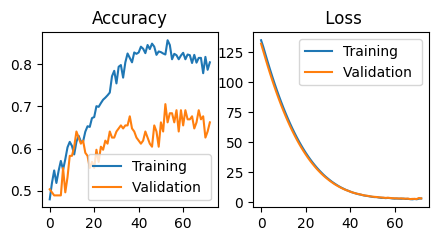

5/5 [==============================] - 0s 3ms/step


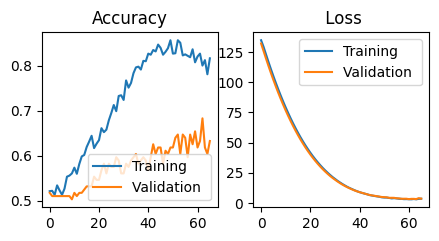

5/5 [==============================] - 0s 2ms/step


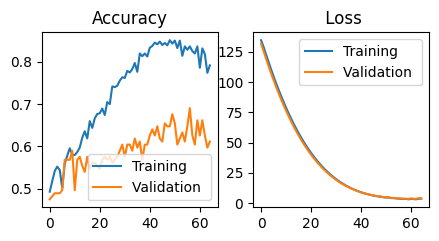

5/5 [==============================] - 0s 3ms/step


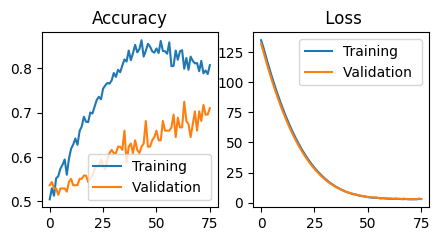

5/5 [==============================] - 0s 3ms/step


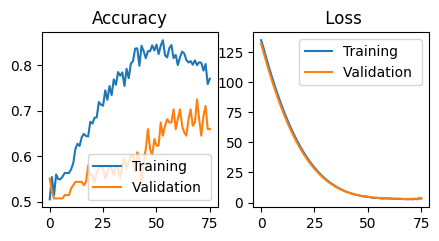

5/5 [==============================] - 0s 3ms/step


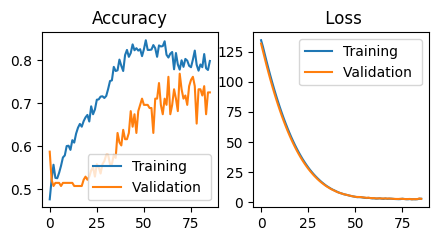

5/5 [==============================] - 0s 3ms/step


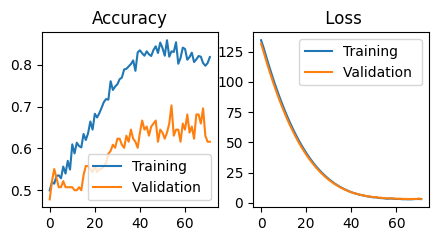

5/5 [==============================] - 0s 2ms/step


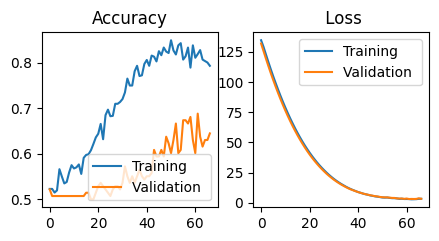

5/5 [==============================] - 0s 3ms/step


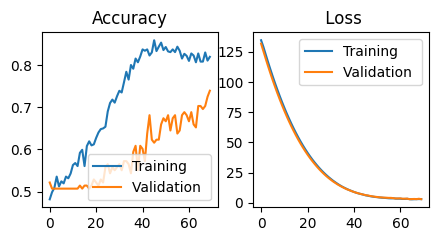

5/5 [==============================] - 0s 3ms/step


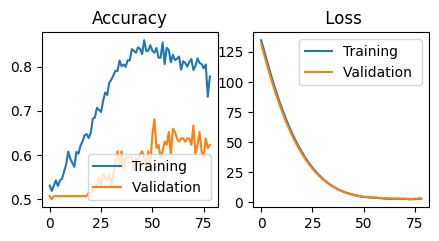

5/5 [==============================] - 0s 3ms/step


In [29]:
cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=rs_) 

for train_index, test_index in cv.split(DF_normalized.iloc[:, 1:], DF_normalized.iloc[:, 0]):
    clear_session() # to ensure that no weights of other folds remain in memory

    df_train, df_test = DF_normalized.iloc[train_index,:], DF_normalized.iloc[test_index,:]
        
    X_train, X_test = df_train.iloc[:, 1:], df_test.iloc[:, 1:]
    y_train, y_test = df_train.iloc[:, 0], df_test.iloc[:, 0]

    #load the model
    model_funct = functional_model()

    # Compile the model
    model_funct.compile(optimizer=SGD(learning_rate = 0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Fit data to model
    history = model_funct.fit(X_train, y_train,
          batch_size=64,
          epochs=150,
          validation_data = (X_test, y_test),
          verbose=0,
          callbacks=[reduce_on_plateau, early_stop])

        ###########################################################
    
    #Train and validation accuracy
    
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training ')
    plt.plot(history.history['val_accuracy'], label='Validation ')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    #Train and validation loss
    
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training ')
    plt.plot(history.history['val_loss'], label='Validation ')
    plt.legend(loc='upper right')
    plt.title(' Loss')
    plt.show()
    
    ###########################################################
    # prepare for SHAP
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # Use SHAP to explain predictions
    explainer = shap.GradientExplainer(model_funct, [X_train]) # the explainer is initialized on training set
    shap_values = explainer.shap_values(X_test) # the values are computed on the validation set

    #  SHAP information per fold per sample
    
    shap_values_per_cv.append(shap_values[:138])
    
        ###########################################################
    _, val_acc = model_funct.evaluate(df_test.iloc[:, 1:], df_test.iloc[:, 0], verbose=0)
    acc.append(val_acc)

        #Compute Receiver operating characteristic (ROC)
    i=0
    preds = model_funct.predict(df_test.iloc[:, 1:], verbose=1)
    fpr, tpr, _ = roc_curve(df_test.iloc[:, 0], preds)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    AUC.append(roc_auc)
    i += 1

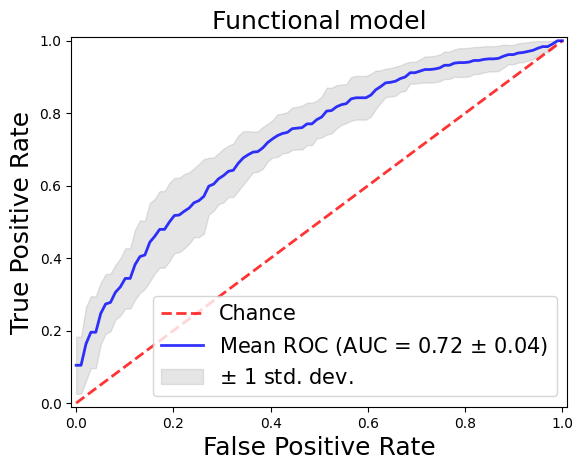

In [30]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(interp_fpr, mean_tpr)
std_auc = np.std(AUC)
plt.plot(interp_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Functional model',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [31]:
print(len(AUC))
print(f'AUC: {np.mean(AUC):.4f} (+- {np.std(AUC):.4f})')
print(f'accuracy: {np.mean(acc):.4f} (+- {np.std(acc):.4f})')

10
AUC: 0.7223 (+- 0.0445)
accuracy: 0.6624 (+- 0.0442)


In [32]:
average_shap_values_f = []

for i in range(0, len(AUC)):
    df_per_obs = shap_values_per_cv[i].copy()
    df_per_obs = np.absolute(df_per_obs)
    average_shap_values_f.append(df_per_obs.mean(axis=0))

fold_f = np.array(average_shap_values_f)[...,0]

In [33]:
fold_f.shape

(10, 5253)

In [34]:
mean_f = np.mean(fold_f, axis = 0)
std_f = np.std(fold_f, axis = 0)

In [35]:
shap_funct = pd.DataFrame({"SHAP_values": mean_f}, index = df_train.iloc[:, 1:].columns)
shap_funct['std']=std_f
shap_funct = shap_funct.sort_values(by='SHAP_values', ascending=False)
shap_funct

,SHAP_values,std
731,0.005177,0.001984
1611,0.004509,0.001657
4543,0.004161,0.000883
2603,0.004125,0.002179
3228,0.004104,0.001591
...,...,...
2757,0.000246,0.000110
5022,0.000236,0.000110
4602,0.000224,0.000125
3838,0.000213,0.000114


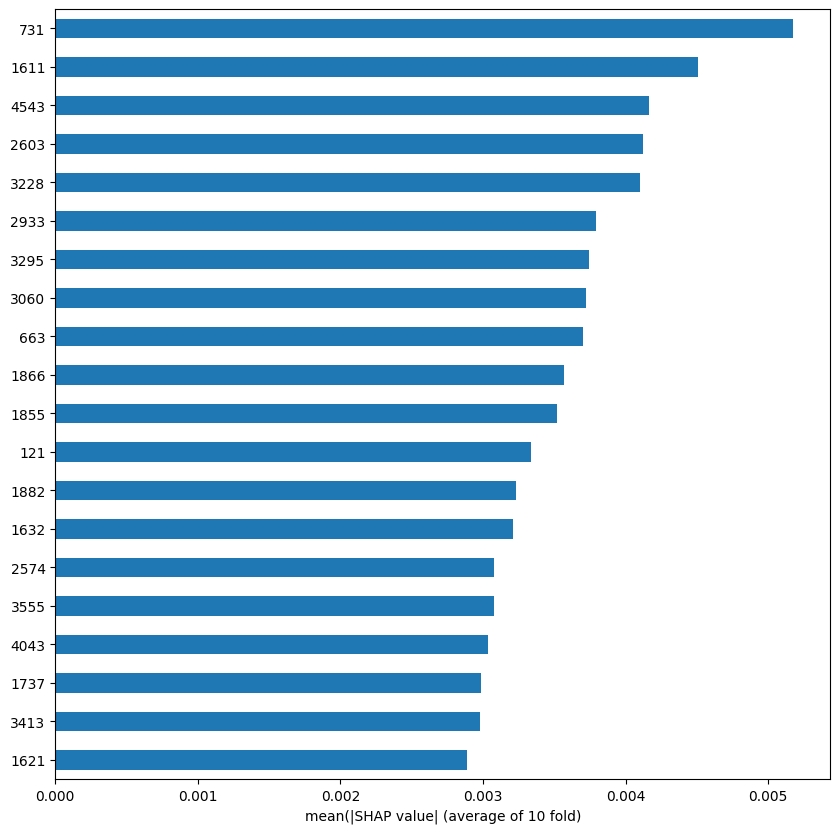

In [41]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = shap_funct.iloc[:20,0].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value| (average of 10 fold)")
plt.show()

<Figure size 4000x5000 with 0 Axes>

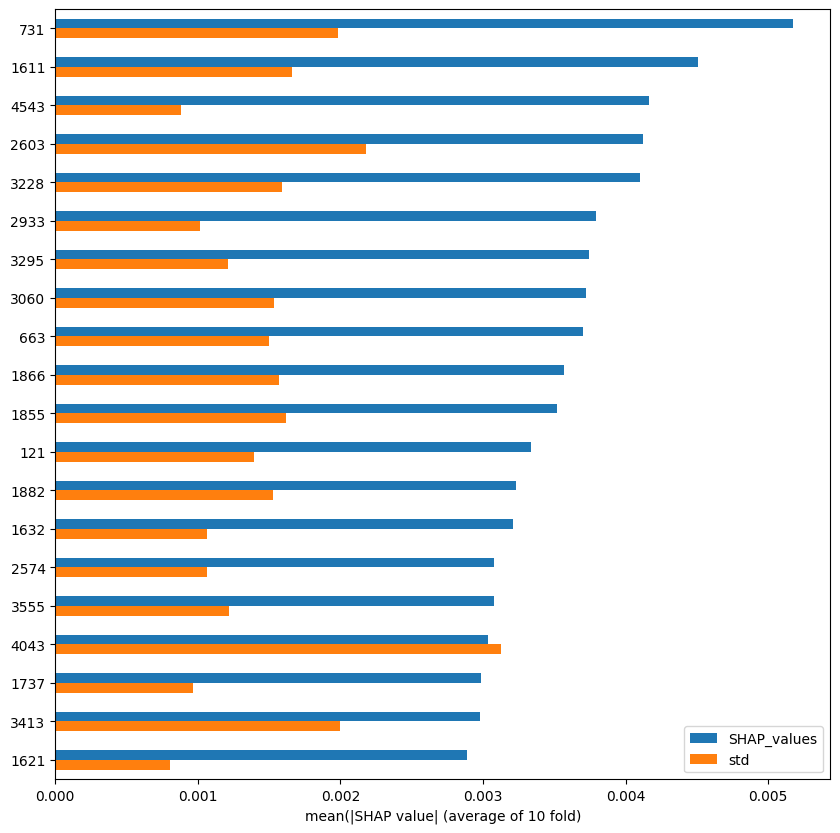

In [42]:
ax2 = plt.figure(figsize=(40, 50))
ax2 = shap_funct.iloc[:20].plot(kind="barh", figsize=(10,10))
ax2.invert_yaxis()
plt.xlabel("mean(|SHAP value| (average of 10 fold)")
plt.show()

In [38]:
feature_index = int(shap_funct.index[0])
feat_name = functional_names.loc[feature_index]
feat_name

ROI 1                                                   49
ROI 2                                                 1301
r1                                          Right Thalamus
r2       Right Middle Temporal Gyrus, temporooccipital ...
Name: 731, dtype: object